In [2]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [3]:
dataset = pd.read_csv("train.csv")
final_test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [4]:
dataset.shape

(15819, 3)

In [5]:
final_test.shape

(10546, 2)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [7]:
dataset.head(2)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103


In [8]:
final_test.head(2)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326


In [9]:
y = dataset['sentiment']
X = dataset.drop(columns=['sentiment', 'tweetid'])
F_test = final_test.drop(columns='tweetid')

In [10]:
X.head(2)

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...


In [11]:
y.unique()

array([ 1,  2,  0, -1], dtype=int64)

In [58]:
# Working_text to test
text = X.iloc[6,0]
print(text)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


In [60]:
working_df = dataset.copy()

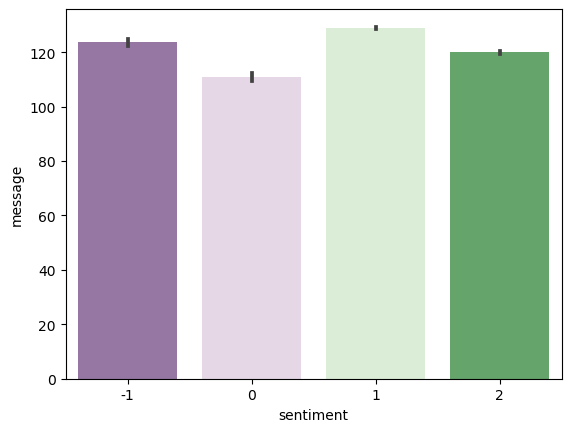

In [14]:
sns.barplot(x='sentiment', y=dataset['message'].apply(len) ,data = dataset,palette='PRGn')

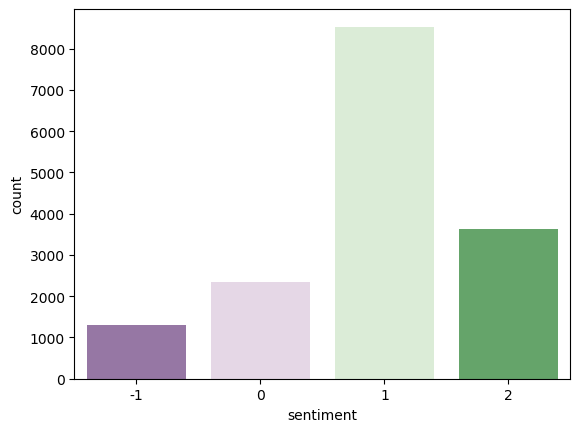

In [15]:
sns.countplot(x='sentiment' ,data = dataset,palette='PRGn')

Preprocessing

firstly, i want to see if any of the users are repeated.

In [16]:
working_x = dataset.copy()

In [17]:
working_x['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in X.message]



In [18]:
counts = working_x[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [19]:
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [20]:
counts['message'][counts['message'] > 1].sum()/len(counts['message'])

0.8567911960613959

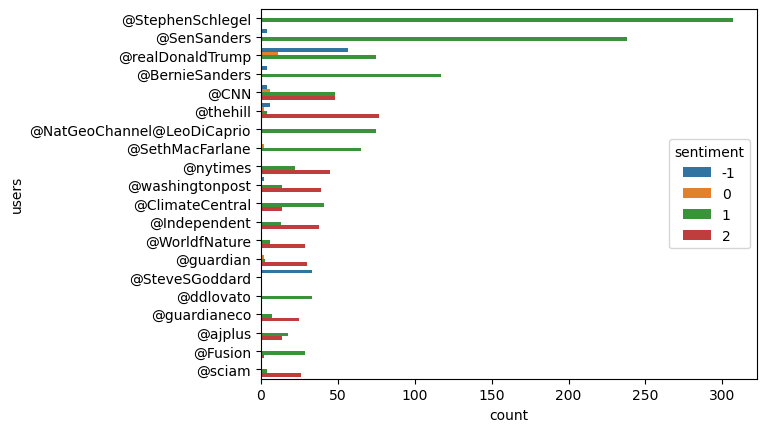

In [21]:
sns.countplot(y="users", hue="sentiment", data=working_x,
              order=working_x.users.value_counts().iloc[:20].index)
#plt.xticks(rotation=90)

I will not be removing users, as we can see that they have contribute to the analysis

In [22]:
X

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...
2,RT @RawStory: Researchers say we have three ye...
3,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."
...,...
15814,RT @ezlusztig: They took down the material on ...
15815,RT @washingtonpost: How climate change could b...
15816,notiven: RT: nytimesworld :What does Trump act...
15817,RT @sara8smiles: Hey liberals the climate chan...


pip install nlppreprocess

In [57]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('shouldnt')

'should not'

In [52]:
nlp.process('There is no stopword here')

'There no stopword'

In [31]:
text

'RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R'

In [53]:
def cleaner(line):

    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) # Removes RT and url
    punctuation = re.compile("[.;:@!\'’‘“”?,\"()\[\]]")
    tweet = punctuation.sub("", line.lower()) # Removes puctuation
    nlp = NLP()
    tweet = nlp.process(tweet) # This will remove stops words that are not necessary. The idea is to keep words like [is, not, was]
    # https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52

    return tweet

In [54]:
text1 = cleaner(text)
print(text1)
# In the tweet below, you can see that "not" was added from "doesn't" and kept, because the word is significant

thenation mike pence not believe in global warming smoking causes lung cancer


In [26]:
text

'RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R'